# Loading data

In [1]:
import pandas as pd

artificial_train = pd.read_csv('data/artificial_train.data', sep=' ', header=None).dropna(axis=1)
artificial_train_labels = pd.read_csv('data/artificial_train.labels', sep=' ', header=None).dropna(axis=1)
artificial_train_labels = artificial_train_labels[0].values
artificial_test = pd.read_csv('data/artificial_valid.data', sep=' ', header=None).dropna(axis=1)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(artificial_train, artificial_train_labels, test_size=0.2, random_state=42)

# Feature selection

## Logistic regression with L1 loss

In [16]:
import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

list_of_regularisation_values = [0.00008, 0.0001, 0.0002, 0.0003, 0.0006, 0.001, 0.003]
list_of_accuracies_valid = []
list_of_accuracies_train = []
list_of_numbers_of_features = []
for regularisation_value in tqdm.tqdm(list_of_regularisation_values):
    lr = LogisticRegression(C=regularisation_value, random_state=1, penalty='l1', solver='liblinear')
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_valid_pred = lr.predict(X_valid)
    list_of_accuracies_valid.append(accuracy_score(y_valid, y_valid_pred))
    list_of_accuracies_train.append(accuracy_score(y_train, y_train_pred))
    list_of_numbers_of_features.append(sum(lr.coef_[0] != 0))

100%|██████████| 7/7 [00:22<00:00,  3.26s/it]


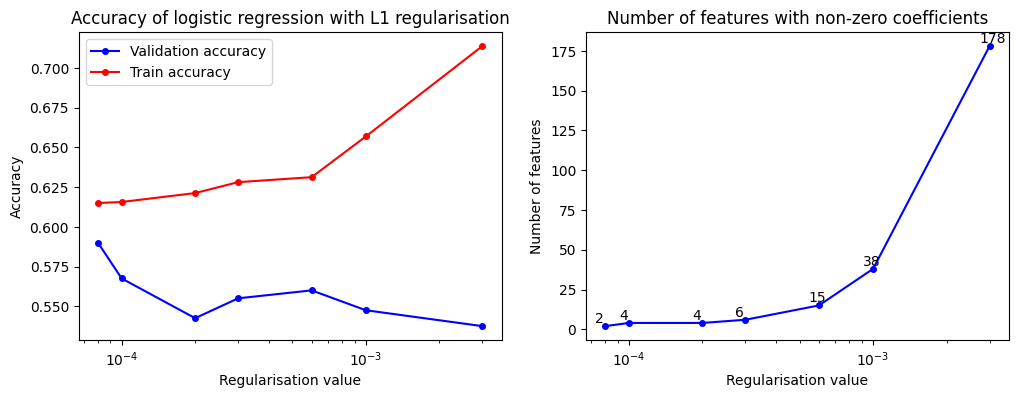

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot accuracy wrt penalty value
ax[0].plot(list_of_regularisation_values, list_of_accuracies_valid, 'o-', label='Validation accuracy', color='blue', markersize=4)
ax[0].plot(list_of_regularisation_values, list_of_accuracies_train, 'o-', label='Train accuracy', color='red', markersize=4)
ax[0].set_xscale('log')
ax[0].set_title('Accuracy of logistic regression with L1 regularisation')
ax[0].set_xlabel('Regularisation value')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# plot number of features wrt penalty value
ax[1].plot(list_of_regularisation_values, list_of_numbers_of_features, 'o-', color='blue', markersize=4)
# add number to each dot
for i, txt in enumerate(list_of_numbers_of_features):
    ax[1].annotate(txt, (list_of_regularisation_values[i]/1.1, list_of_numbers_of_features[i]+2))
ax[1].set_xscale('log')
# ax[1].set_yscale('log')
ax[1].set_title('Number of features with non-zero coefficients')
ax[1].set_xlabel('Regularisation value')
ax[1].set_ylabel('Number of features')
plt.show()